In [1]:
import os
import tempfile
from dataclasses import dataclass

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from groundingdino.util.inference import annotate, load_image, load_model, predict
from PIL import Image
from sam2.build_sam import build_sam2_video_predictor
from torch import Tensor
from torchvision.ops import box_convert

In [2]:
gd_model = load_model(
    "../libs/groundingdino/groundingdino/config/GroundingDINO_SwinT_OGC.py",
    "../checkpoints/groundingdino_swint_ogc.pth",
)

sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
model_cfg = "sam2.1_hiera_s.yaml"
sam2_model = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device="cuda")

final text_encoder_type: bert-base-uncased


In [3]:
VIDEO_PATH = "./scenevideo.mp4"


def extract_frames(video_path):
    if not os.path.isfile(video_path):
        raise FileNotFoundError(f"The file {video_path} does not exist.")

    temp_dir = tempfile.mkdtemp()
    video_capture = cv2.VideoCapture(video_path)
    frame_count = 0
    success, frame = video_capture.read()

    while success:
        frame_filename = os.path.join(temp_dir, f"{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        success, frame = video_capture.read()
        frame_count += 1

    video_capture.release()
    return temp_dir


frames_dir = extract_frames(VIDEO_PATH)

In [4]:
frame_names = [f for f in os.listdir(frames_dir)]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

print(f"Found {len(frame_names)} frames.")

Found 854 frames.


In [5]:
def show_image(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [6]:
@dataclass
class DetectionResult:
    phrase: str
    frame_idx: int
    box: Tensor
    logit: Tensor
    frame_path: str

    def get_annotated(self):
        img = cv2.imread(self.frame_path)

        return annotate(
            image_source=img, boxes=self.box.unsqueeze(0), logits=self.logit.unsqueeze(0), phrases=[self.phrase]
        )


def find_objects(
    frames_dir: str,
    prompts: list[str],
    start_frame: int,
    end_frame: int,
    box_treshold: float,
    text_treshold: float,
    step: int = 16,
):
    """
    Find objects in the video between start_frame and end_frame.

    Args:
      prompts: List of prompts to search for.
      start_frame: Start frame index.
      end_frame: End frame index.
      step: Number of steps to take in the frame range.
    """

    results = {}
    frame_step = (end_frame - start_frame) // step
    frame_idx = start_frame + frame_step
    prompts_to_search = set(prompts)

    while end_frame - frame_idx > frame_step:
        frame_path = os.path.join(frames_dir, frame_names[frame_idx])
        _, image = load_image(frame_path)
        boxes, logits, phrases = predict(
            model=gd_model,
            image=image,
            caption=". ".join(prompts_to_search),
            box_threshold=box_treshold,
            text_threshold=text_treshold,
        )

        for i, phrase in enumerate(phrases):
            if phrase in results:
                results[phrase].append(DetectionResult(phrase, frame_idx, boxes[i], logits[i], frame_path))
            else:
                results[phrase] = [DetectionResult(phrase, frame_idx, boxes[i], logits[i], frame_path)]

        prompts_to_search = prompts_to_search - set(phrases)
        frame_idx += frame_step

    return results

In [7]:
PROMPTS = ["nameplate"]
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

results = find_objects(frames_dir, PROMPTS, 0, len(frame_names) - 1, BOX_TRESHOLD, TEXT_TRESHOLD)
results

{'nameplate': [DetectionResult(phrase='nameplate', frame_idx=53, box=tensor([0.9477, 0.9141, 0.0374, 0.0842]), logit=tensor(0.4523), frame_path='/tmp/tmpgogsku4p/0053.jpg'),
  DetectionResult(phrase='nameplate', frame_idx=53, box=tensor([0.8799, 0.6949, 0.0603, 0.0737]), logit=tensor(0.3876), frame_path='/tmp/tmpgogsku4p/0053.jpg')]}

tensor([0.9477, 0.9141, 0.0374, 0.0842]) nameplate


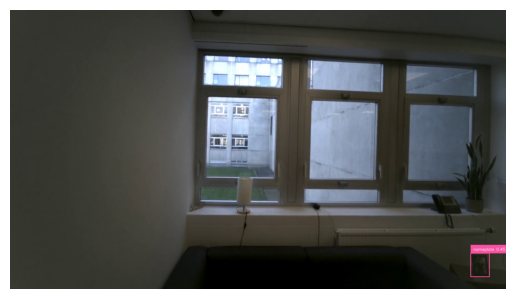

tensor([0.8799, 0.6949, 0.0603, 0.0737]) nameplate


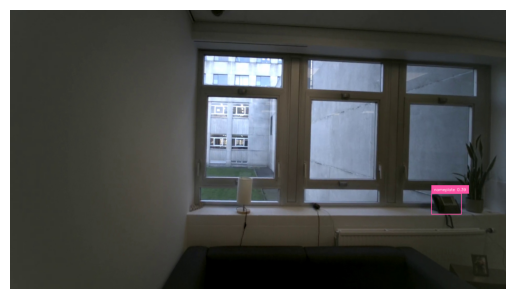

In [8]:
# annotated_frames = [ detection.show_box() for detections in results.values() for detection in detections ]

# for frame in annotated_frames:
#     show_image(frame)
# Flatten results and show each detection
detections = [detection for detections in results.values() for detection in detections]

for detection in detections:
    print(detection.box, detection.phrase)
    annotated = detection.get_annotated()
    show_image(annotated)

In [9]:
@dataclass
class ObjectTrack:
    phrase: str


def track_objects(detections: list[DetectionResult], inference_state):
    tracks = {detection.phrase: [] for detection in detections}
    phrase_ids = {detection.phrase: i for i, detection in enumerate(detections)}

    for i, detection in enumerate(detections):
        frame_idx = detection.frame_idx
        track_id = i

        img = cv2.imread(detection.frame_path)
        w, h = img.shape[1], img.shape[0]
        box = detection.box * torch.Tensor([w, h, w, h])
        xyxy = box_convert(boxes=box.unsqueeze(0), in_fmt="cxcywh", out_fmt="xyxy").numpy()

        sam2_model.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=frame_idx,
            obj_id=track_id,
            box=xyxy,
        )

In [10]:
inference_state = sam2_model.init_state(video_path=frames_dir)

frame loading (JPEG): 100%|██████████| 854/854 [00:21<00:00, 40.29it/s]


In [11]:
sam2_model.reset_state(inference_state)
track_objects(detections, inference_state)


Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).


In [12]:
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in sam2_model.propagate_in_video(
        inference_state, start_frame_idx=0
    ):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() for i, out_obj_id in enumerate(out_obj_ids)
        }

propagate in video:  35%|███▌      | 302/854 [01:59<03:38,  2.53it/s]  


KeyboardInterrupt: 

: 

In [ ]:
output_dir = "./output/"
import shutil

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)
# Process frames in smaller batches
BATCH_SIZE = 50  # Adjust based on your available memory

import colorsys
import shutil


def generate_color(id: int, alpha: float = 0.6) -> np.ndarray:
    # Number of distinct hues you want before cycling (e.g., 360 for degrees)
    # Increasing this can provide more distinct colors but may require more hue space
    num_hues = 360
    hue = (id * 137) % num_hues  # 137 is a prime number to help distribute colors
    hue_normalized = hue / num_hues  # Normalize hue to [0, 1] for colorsys

    # Fixed saturation and value for vibrant colors
    saturation = 0.7
    value = 0.9

    # Convert HSV to RGB
    rgb = colorsys.hsv_to_rgb(hue_normalized, saturation, value)

    # Append alpha to get RGBA
    rgba = np.array([*rgb, alpha])

    return rgba


from tqdm.notebook import tqdm

for batch_start in range(0, len(frame_names), BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, len(frame_names))

    for out_frame_idx in tqdm(
        range(batch_start, batch_end),
        desc=f"Processing batch {batch_start // BATCH_SIZE + 1}/{len(frame_names) // BATCH_SIZE + 1}",
    ):
        try:
            # Clear memory after each frame
            img = None
            mask_overlay = None
            base_img = None

            # Load and convert base image
            base_img = Image.open(os.path.join(frames_dir, frame_names[out_frame_idx]))
            img = base_img.convert("RGBA")

            # Get masks for this frame
            frame_masks = video_segments.get(out_frame_idx, {})

            for out_obj_id, out_mask in frame_masks.items():
                color = generate_color(out_obj_id)
                h, w = out_mask.shape[-2:]
                mask_image = out_mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

                mask_overlay = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")
                img = Image.alpha_composite(img, mask_overlay)

            # Save the final image
            img = img.convert("RGB")
            output_path = os.path.join(output_dir, f"{out_frame_idx:04d}.jpg")
            img.save(output_path)

        except Exception as e:
            print(f"Error processing frame {out_frame_idx}: {e!s}")
            continue
        finally:
            # Clean up resources
            if img is not None:
                del img
            if mask_overlay is not None:
                del mask_overlay
            if base_img is not None:
                del base_img